<a href="https://colab.research.google.com/github/anvelezec/experiments/blob/master/Basic_NN_using_JAX_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import matplotlib.pyplot as plt

# **NN using JAX**

This notebook has as goal to point in a clear way how to use **JAX** grad function in optimization models. We ilustrate it with a simple neural network with one layer. At the end we compare the results of both found and real parameters used to simulated data.


# **Parameter definition**

In [2]:
size = 10
W_real = np.array([2.5]).reshape((1,1))
X = np.linspace(0, 10, size).reshape((1, size))
b_real = 0.5

In [3]:
y_true = W_real.T.dot(X) + b_real

In [4]:
print(y_true)
print(X)

[[ 0.5         3.27777778  6.05555556  8.83333333 11.61111111 14.38888889
  17.16666667 19.94444444 22.72222222 25.5       ]]
[[ 0.          1.11111111  2.22222222  3.33333333  4.44444444  5.55555556
   6.66666667  7.77777778  8.88888889 10.        ]]


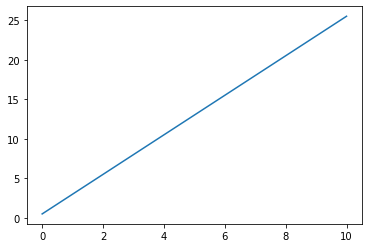

In [5]:
plt.plot(X.T, y_true.T)

# **Forward layer definition**

In [6]:
def forward(X, W, b):
  y_pred = W.T.dot(X) + b
  return y_pred

In [7]:
# Initialization
i_neurons = 1
o_neurons = 1

b = np.random.rand(1).reshape((1, 1))
W = np.random.rand(i_neurons, o_neurons)
X = np.linspace(0, 10, 10).reshape((1, 10))

In [8]:
y_pred = forward(X, W, b)
print(y_pred)

[[0.36652577 0.76054568 1.15456558 1.54858549 1.9426054  2.3366253
  2.73064521 3.12466512 3.51868502 3.91270493]]


# **Loss function definition (MSE)**

In [9]:
def loss(y_true, y_pred):
  error = jnp.mean(jnp.power(y_true - y_pred, 2))
  return error

In [10]:
x1 = np.array([0.5, 1.2])
x2 = np.array([0.5, 1.2])
jnp.mean(jnp.power(x1 - x2, 2))

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(0., dtype=float32)

In [11]:
# Random loss 
loss(y_true=y_true, y_pred=y_pred)

DeviceArray(164.82693, dtype=float32)

# **Wrappers**

## Way 1 to define a wrapper function:
In this format we separate the loss function respect the forward pass


In [12]:
def wrapper1(X, W, b, y_true):
  y_pred = forward(X, W, b)
  error = loss(y_true, y_pred)
  return error

In [13]:
W_grad = grad(wrapper1, argnums=1)(X, W, b, y_true)
b_grad = grad(wrapper1, argnums=2)(X, W, b, y_true)

print(W_grad)
print(b_grad)

[[-152.30608]]
[[-21.720768]]


## Way 2 to define a wrapper function: 
In this format we combine the loss function with the forward pass

In [14]:
# Way 2 to define a wrapper function: In this format we combine the loss function with the forward pass
def wrapper2(X, W, b, y_true):
  y_pred = W.T.dot(X) + b
  error = loss(y_true, y_pred)
  return error

In [15]:
W_grad = grad(wrapper2, argnums=1)(X, W, b, y_true)
b_grad = grad(wrapper2, argnums=2)(X, W, b, y_true)

print(W_grad)
print(b_grad)

[[-152.30608]]
[[-21.720768]]


# **Optimization** 
Using Gradient descent as optimization function. Take into account we are using the JAX **grad** function which facilitates the parameters gradients computation which is equivalent to the partial derivate of the loss function respect all the parameters we need to estimate.

I create two training functions with the aim to test both defined wrappers.

In [16]:
def train1(X, W, b, y_true, learning_rate, epochs):
  for i in range(epochs):
      W -= learning_rate * grad(wrapper1, argnums=1)(X, W, b, y_true)
      b -= learning_rate * grad(wrapper1, argnums=2)(X, W, b, y_true)
      params = {"W": W, "b":b}

      if i % 10 == 0:
          print(wrapper1(X, W, b, y_true))

  return params

In [17]:
def train2(X, W, b, y_true, learning_rate, epochs):
  for i in range(epochs):
      W -= learning_rate * grad(wrapper2, argnums=1)(X, W, b, y_true)
      b -= learning_rate * grad(wrapper2, argnums=2)(X, W, b, y_true)
      params = {"W": W, "b":b}
      
      if i % 10 == 0:
          print(wrapper(X, W, b, y_true))

  return params

# **Parameter initialization**
Using two forms of parameter initialization. This is a really important topic when training models end-to-end.

In [18]:
# Initialization
i_neurons = 1
o_neurons = 1
init = "random"

X = np.linspace(0, 10, size).reshape((1, size))

if init == "random":
  b = np.random.rand(1).reshape((1, 1))
  W = np.random.rand(i_neurons, o_neurons)

if init == "zero":
  b = np.zeros(1).reshape((1, 1))
  W = np.zeros((i_neurons, o_neurons))

print(W)
print(b)

[[0.88927794]]
[[0.35029664]]


# **Training**
When the parameter convergence depend significatively in the parameter initialization and learning rate.

In [19]:
params = train1(X=X, W=W, b=b, y_true=y_true, learning_rate=0.001, epochs=200)
print(params)

80.76137
18.2379
4.1192784
0.93108404
0.21112747
0.04853443
0.011806176
0.003501206
0.0016155271
0.0011799701
0.0010722143
0.0010387257
0.0010221124
0.0010094398
0.0009977681
0.0009864203
0.0009752683
0.00096422917
0.0009533437
0.0009425531
{'W': DeviceArray([[2.491867]], dtype=float32), 'b': DeviceArray([[0.55676645]], dtype=float32)}


# **Prediction and parameter validation**
Generating predictions with estimated parameters. The interesting part here is we were able to estimate aproximately the correct parameters by using the grad function of **JAX** without having to worry too much about the partial differentiation of each parameter with respect the loss function.

In [20]:
W_est = params["W"]
b_est = params["b"]

y_pred = forward(X, W=W_est, b=b_est)

In [21]:
loss(y_true=y_true, y_pred=y_pred)

DeviceArray(0.00093297, dtype=float32)

Text(2, 20, 'y = 2.491867 X + 0.55676645')

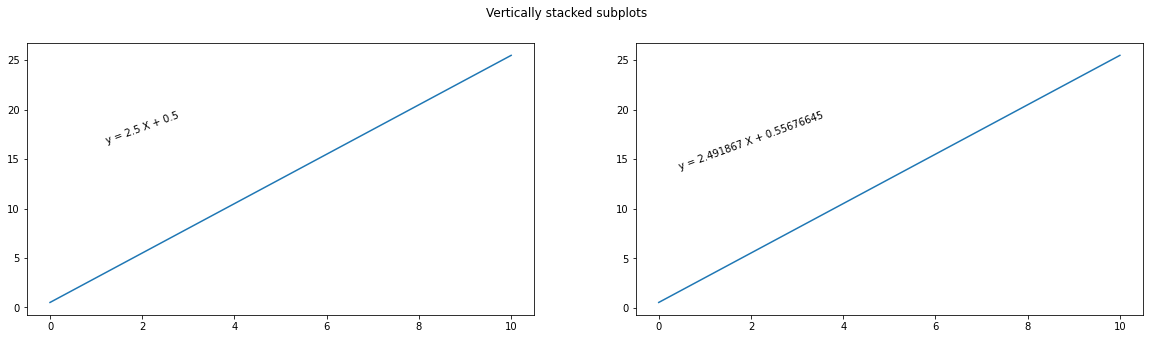

In [22]:
plt.rcParams["figure.figsize"] = (20,5)

fig, axs = plt.subplots(1, 2)
fig.suptitle('Vertically stacked subplots')
axs[0].plot(X.T, y_true.T)
axs[0].text(2, 20, 'y = ' + str(W_real[0][0]) + " X + " + str(b_real),
         rotation=20,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

axs[1].plot(X.T, y_pred.T)
axs[1].text(2, 20, 'y = ' + str(W_est[0][0]) + " X + " + str(b_est[0][0]),
         rotation=20,
         horizontalalignment='center',
         verticalalignment='top',
         multialignment='center')

# References
* https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html
* https://colindcarroll.com/2019/04/06/exercises-in-automatic-differentiation-using-autograd-and-jax/
* https://www.kaggle.com/grez911/tutorial-efficient-gradient-descent-with-jax